Original file is located at
    https://colab.research.google.com/drive/1v2ZyFEgxFrGOA7xp-LB7HoHyngiTxWgP

link main w2v codes used in modello.py:

*   https://www.kaggle.com/ashukr/implementation-of-word2vec-paper
*   https://github.com/fanglanting/skip-gram-pytorch
*   https://github.com/woaiwodib107/SkipGram-word2vec/blob/master/17075036.ipynb


In [ ]:
import re
from collections import Counter
import collections
import random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import math
import os
import json, csv
from math import acos
from scipy.stats import spearmanr
from torch import linalg as LA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from random import *
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/Galvan
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Experiments/Galvan
combined.csv		   model_epoch6_steps153000
final_model.torch	   model_epoch6_steps162000
model_epoch10_steps252000  model_epoch7_steps171000
model_epoch10_steps261000  model_epoch7_steps180000
model_epoch10_steps270000  model_epoch7_steps189000
model_epoch1_steps18000    model_epoch8_steps198000
model_epoch1_steps27000    model_epoch8_steps207000
model_epoch1_steps9000	   model_epoch8_steps216000
model_epoch2_steps36000    model_epoch9_steps225000
model_epoch2_steps45000    model_epoch9_steps234000
model_epoch2_steps54000    model_epoch9_steps243000
model_epoch3_steps63000    risultatisp1.txt
model_epoch3_steps72000    risultatisp2.txt
model_epoch3_steps81000    risultatisp3.txt
model_epoch4_steps108000   similaritacombined.txt
model_epoch4_steps90000    similaritawordsim_relatedness_goldstandard.txt
model_epoch4_steps

Preprocess a text by lowercasing it, substituting punctuation marks, removing infrequent words, and removing stopwords. The result is a list of words.

In [ ]:
def preprocess(text):

    # lowercase
    text = text.lower()

    # separate these punctuation marks from the words in the text and allow the model to treat them differently.
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')

    # splits the text into individual words
    words = text.split()

    # remove words with five or fewer occurrences. reduce the size of the vocabulary and improve the efficiency of the model.
    word_counts = Counter(words)  # dictionary word:occurrences
    trimmed_words = [word for word in words if word_counts[word] > 5]

    # remove common words that do not provide much meaning to the text
    stop = [
    "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "aren't", "as", "at",
    "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
    "can", "can't", "cannot", "could", "couldn't",
    "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during",
    "each",
    "few", "for", "from", "further",
    "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
    "hers", "herself", "him", "himself", "his", "how", "how's",
    "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "isn't", "it", "it's", "its", "itself",
    "just",
    "me", "more", "most", "must", "my", "myself",
    "no", "nor", "not", "now",
    "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
    "same", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such",
    "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
    "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too",
    "under", "until", "up",
    "very",
    "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where",
    "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "won't", "would", "wouldn't",
    "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"
    ]

    trimmed_words = [i for i in trimmed_words if i not in stop]

    print("Preprocessed words, goes: ", trimmed_words[:25])

    return trimmed_words

Function that takes a list of words as input and creates three dictionaries:

*   **vocab_to_int**: maps each word in the input list to a unique integer index.
*   **int_to_vocab**: maps each integer index to the corresponding word in the input list.
*   **count**: a list of tuples, where each tuple contains a word and its frequency in the input list, sorted in descending order by frequency.

Indexing is done on decreasing frequency.

In [ ]:
def create_lookup_tables(words):

    word_counts = Counter(words)  # dictionary "word:number of occurrences"

    count = []  # list of tuples (word, number of occurrences) from most frequent, e.g. [('one', 411764),...]
    count.extend(Counter(words).most_common(len(words)))

    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # list of words sorted in decreasing frequency
    # order of word in this list is its index

    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}  # dictionary index:word {0: 'one',...}

    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}  # dictionary word:index {'one': 0,...}

    print("count, goes: ", count[:25])
    print("int_to_vocab, goes: ", dict(list(int_to_vocab.items())[0: 25]))
    print("vocab_to_int, goes: ", dict(list(vocab_to_int.items())[0: 25]))


    return vocab_to_int, int_to_vocab, count


Read in the text from "text8", preprocesses it, and creates lookup tables for the words in the text.

It then converts each word in the text to its corresponding index from the lookup tables.

In [ ]:
# DOWNLOAD
# text8: http://mattmahoney.net/dc/textdata.html
with open('text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

vocab_to_int, int_to_vocab, count = create_lookup_tables(words)

int_words = [vocab_to_int[word] for word in words]  # list of words but as their indexes, not unique!
print("int_words, goes: ", int_words[0: 25])

Preprocessed words, goes:  ['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe']
Total words in text: 8736003
Unique words: 63480
count, goes:  [('first', 28810), ('many', 24096), ('new', 23770), ('used', 22737), ('american', 20477), ('time', 20412), ('see', 19206), ('may', 19115), ('world', 17949), ('b', 17516), ('would', 17377), ('however', 15861), ('years', 14935), ('states', 14916), ('people', 14696), ('war', 14629), ('united', 14494), ('known', 14437), ('called', 14151), ('use', 14011), ('th', 13380), ('system', 13296), ('often', 12987), ('state', 12904), ('history', 12623)]
int_to_vocab, goes:  {0: 'first', 1: 'many', 2: 'new', 3: 'used', 4: 'american', 5: 'time', 6: 'see', 7: 'may', 8: 'world', 9: 'b', 10: 'would', 11: 'however', 12: 'years', 13: 'states', 14: 'people', 15

Sub-sampling of frequent words in a given text corpus

Compute the relative frequency of each word in the given text

Assigns a probability of dropping each word during training, based on their relative frequency.

$p_{drop}(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$

Higher the frequency, higher chances of dropping its **occurance**!

The remaining words are stored in the list train_words.

In [ ]:
# SUBSAMPLING

threshold = 1e-5

word_counts = Counter(int_words)
total_count = len(int_words)

freqs = {word: count / total_count for word, count in word_counts.items()} # dict word_idx:rel_freq
p_drop = {word: 1 - np.sqrt(threshold / freqs[word]) for word in word_counts} # dict word_idx:prob_dropping

train_words = [word for word in int_words if random.random() < (1 - p_drop[word])] # list of words after subsampling

print("First 20 train_words", train_words[:20])  # list containing integers associated with text words in the order...

print("Total words for training: {}".format(len(train_words)))
print("Unique words for training: {}".format(len(set(train_words))))

First 20 train_words [2944, 2996, 358, 10423, 27190, 14915, 57951, 3439, 95, 10564, 1191, 2596, 3531, 259, 5092, 44450, 2742, 5092, 478, 1006]
Total words for training: 3493887
Unique words for training: 63480


Takes a list $count$ that contains tuples of (word, count) and returns a sampling table of the indices of the words in the vocabulary.

*   Extracts the counts of each word from the input $count$ list and raises these counts to the power of 0.75.
*   The resulting power frequency distribution is normalized and used to determine how many times each word should be added to the fixed size of 1e8 sampling table, stored in a list $sampling\_count$.
*   Creates the sampling table by repeating each word's index in the vocabulary by the number of times specified in $sampling\_count$.
*   Returns the resulting numpy array.

**During training, negative samples are drawn randomly from this table, with more frequent words being more likely to be sampled, but with less frequent words still having a non-zero chance of being sampled.**





In [ ]:
# Create a sampling table for neg sampling, each element appears number of times relative to its frequency.

def init_sample_table(count):
    count = [ele[1] for ele in count] # List of number of occurances, sorted; [occ1, occ2, occ3...]

    pow_frequency = np.array(count) ** 0.75 # Power occurances by .75
    power = sum(pow_frequency) # for normalization
    ratio = pow_frequency / power # relative power frequencies list

    table_size = 1e8
    sampling_count = np.round(ratio * table_size) # how many times an element should be added to the sampling table

    sample_table = []
    for idx, x in enumerate(sampling_count):
        sample_table += [idx] * int(x) # add each word's idx to the table, number of times specificed in sampling_count

    print("sample_table created, goes: ", sample_table[:25])
    return np.array(sample_table)

In [ ]:
sample_table = init_sample_table(count)

sample_table created, goes:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Calculate the weight table for negative sampling. The weight table is an array of probabilities that is used to randomly sample negative examples during training.

*   Takes a list of (word, count) tuples as input, where count is the number of times each word appears in the training data.
*   Returns an array of weights that is proportional to the frequency of each word to the 0.75 power.
*   The weights are normalized to sum to 1.0.

**[UNUSED]**





In [ ]:
# UNUSED
def weight_table(count):
    count = [ele[1] for ele in count]
    pow_frequency = np.array(count) ** 0.75
    power = sum(pow_frequency)
    ratio = pow_frequency / power
    return np.array(ratio)

Saves the vocabulary words and their corresponding counts to a file named "voca.txt" in the current working directory.

In [ ]:
def save_vocab(count, vocab_words):
    with open(os.path.join("voca.txt"), "w") as f:
        for i in range(len(count)):
            vocab_word = vocab_words[i]
            f.write("%s %d\n" % (vocab_word, count[i][1]))


In [ ]:
save_vocab(count, int_to_vocab)

Takes in a list of words, an index (idx), and a window size. It returns a list of **unique** target words within the window size around the given index.



*   Generates a random window size between 3 and the specified window size.
*   Calculates the starting and stopping indices of the window based on the given index and the window size.
*   Creates a list of target words by slicing the list of words from the start index to the given index (excluding the word at the given index) and from the given index plus 1 to the stop index.
*   Finally, it returns the list of **unique** target words in the window.

In [ ]:
# returns list of words in context window around the central word

def get_target(words, idx, window_size=5):

    # R=window_size
    R = np.random.randint(3, window_size + 1) # Randomized window size

    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx + 1:stop + 1]

    return list(set(target_words))

This function generates batches of training data for the Skip-gram model. Here's what it does:

Inputs:


*   words: A list of integers representing the indices of words in the vocabulary.
*   batch_size: An integer representing the number of training samples per batch.
*   window_size: An integer representing the size of the context window.
*   neg_sample_num: An integer representing the number of negative samples to generate for each training sample.

Outputs:
*   A **generator** that yields training batches of central words and corresponding target word pairs and negative samples.

Steps:
* Adjust the number the input words for the size $batch\_size$.
* For each batch:
>* For each word in the batch:
>>* Generate a list of target words using the get_target function.
>>* Add the central word and the target words to separate lists.
>>*Keep track of the starting and ending indices of each training sample in the x and y lists using a list of tuples z.
>>* In a seperate list, generate second target words for the 3rd order.
>>* Generate negative samples for each central word using the sample_table.
>* Yield tuples of training data consisting of:
>>* A list of central words.
>>* Two lists of target words.
>>* A 2D NumPy array of negative samples for each context word.

In [ ]:
def get_batches(words, batch_size, window_size=5, neg_sample_num=5):

    n_batches = len(words) // batch_size
    words = words[:n_batches * batch_size] # keep only the number of words to match the bath_size and n_batches

    for idx in range(0, len(words), batch_size): # for each batch in words
        centrali = []  # list containing central words
        contesto1 = []  # list of words in the context, second order
        contesto3 = []  # list of words in the context, third order

        x, y = [], [] # lists that store the central and context words for each training sample
        z = [] # list of tuples that stores the starting and ending indices of each training sample in the x and y lists
        a = 0 # Counter for the total number of training samples seen so far. Used to keep track of the indices in z.

        batch = words[idx:idx + batch_size] # one batch; batch_size number of words (unique), starting from index idx

        for ii in range(len(batch)): # in a batch

            batch_x = batch[ii] # central word for a given training sample
            batch_y = get_target(batch, ii, window_size) # list of context words for that central word

            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y)) # central word added, repeated by the number of target words
            z.extend([[a, len(x)]] * len(batch_y)) # a -> starting idx, len(x) -> end index (for one training sample)

            a = a + len(batch_y)

            centrali.extend([batch_x] * len(batch_y) * (len(batch_y) - 1)) # central word repeated by 2 comb of target words in batch
            for i in range(len(batch_y)): # for each target word in the batch
                contesto1.extend([batch_y[i]] * (len(batch_y) - 1)) # each target word, by number of target words

        for i in range(len(z)):
            valori = list(range(z[i][0], z[i][1]))
            valori.remove(i) # contesto1[i] <> contesto3[i]
            for v in valori:
                contesto3.extend([y[v]]) # words for 3rd order, for each target word, every other target word

        # for an i,
        # centrali[i] -> a central word
        # contesto1[i] and contesto3[i] -> 2 different target words, each in the context of central word
        # neg_v[i] -> list of neg sample words to pair with the target word at contesto1[i]

        neg_v = np.random.choice(sample_table, size=(len(centrali), neg_sample_num))  # list of negative samples for each context word
        for i in range(len(contesto1)):
            for j in range(neg_sample_num):
                if contesto1[i] == neg_v[i][j]:
                    while (contesto1[i] == neg_v[i][j]):
                        neg_v[i][j] = sample_table[random.randint(0, len(sample_table))] # negative sample, make it different than target words

        yield centrali, contesto1, contesto3, neg_v


In [ ]:
int_text = train_words[:100]
centrali, contesto1, contesto3, neg_v = next(get_batches(int_text, batch_size=20, window_size=5))

print("centrali",centrali)
print("contesto1", contesto1)
print("contesto3", contesto3)
print("neg_v",neg_v)

centrali [2944, 2944, 2944, 2944, 2944, 2944, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 2996, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 358, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 10423, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 27190, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 14915, 1

Computes the cosine similarity between a set of validation words and all the words in the vocabulary, using the trained embedding matrix.

* $embedding$ argument is the trained embedding matrix, $valid\_size$ is the number of validation words for which to compute similarity, and $valid\_window$ is the range of indices from which to sample the validation words.

* The function first computes the magnitudes of all the word embedding vectors and stores them in $magnitudes$. Then it samples $valid\_size$ validation words by randomly selecting $valid\_size$/2 words from the range $valid\_window$ and $valid\_size$/2 words from the range 1000 to 1000 + $valid\_window$.

* It then retrieves the embedding vectors for these validation words from the embedding matrix and stores them in $valid\_vectors$.

* Next, it computes the dot product between $valid\_vectors$ and all the embedding vectors in $embed\_vectors$ and divides the result by the magnitudes of the embedding vectors to obtain the cosine similarity. The resulting similarities are stored in the $similarities$ tensor.

* Finally, the function returns two tensors: $valid\_examples$, which contains the indices of the validation words, and $similarities$, which contains the cosine similarities between the validation words and all the words in the vocabulary.

In [ ]:
def cosine_similarity1(embedding, valid_size=16, valid_window=100, device='cpu'):
    embed_vectors = embedding.weight
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)

    valid_examples = np.array(random.sample(range(valid_window), valid_size // 2))
    valid_examples = np.append(valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size // 2))
    valid_examples = torch.LongTensor(valid_examples).to(device)

    valid_vectors = embedding(valid_examples)

    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes

    return valid_examples, similarities


Calculates cosine similarity between two vectors using the standard formula. Assumes that v1 and v2 are both numpy arrays of the same length.

In [ ]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i];
        y = v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)


Computing a score for the performance of a word embedding model on a word similarity task.

* It reads in a vocabulary file and a file with word pairs and their corresponding human similarity scores.
* Then for each word pair in the file, it retrieves the corresponding embedding vectors from the model and computes the cosine similarity between them.
* The computed cosine similarity scores are compared to the human similarity scores using the Spearman's rank correlation coefficient.
* Finally, the function returns the correlation coefficient as a measure of the model's performance.
* The parameter epoca appears to be used to determine whether to write the computed cosine similarity scores to a file or not, depending on the value of the parameter.

In [ ]:
def scorefunction(embed, epoca):

    f = open('voca.txt')
    line = f.readline()

    vocab = [] #?
    wordindex = dict()
    index = 0

    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()

    f.close()

    ze = []

    with open('combined.csv') as csvfile:
        filein = csv.reader(csvfile)
        index = 0
        consim = []
        humansim = []

        for eles in filein:
            if index == 0:
                index = 1
                continue
            if (eles[0] not in wordindex) or (eles[1] not in wordindex):
                continue

            word1 = int(wordindex[eles[0]])
            word2 = int(wordindex[eles[1]])
            humansim.append(float(eles[2]) / 10 * 2 - 1) #####################

            value1 = embed[word1]
            value2 = embed[word2]
            index = index + 1
            score = cosine_similarity(value1, value2)
            consim.append(score)

            if epoca == 9:
                with open(os.path.join("similaritacombined.txt"), "a") as f:
                    f.write("%s %s %f\n" % (eles[0], eles[1], score))

    cor1, pvalue1 = spearmanr(humansim, consim)

    return cor1

In [ ]:
def scorefunction1(embed, epoca):
    f = open('voca.txt')
    line = f.readline()
    vocab = []
    wordindex = dict()
    index = 0
    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()
    f.close()
    ze = []

    if 1 == 1:
        lines = open('wordsim_similarity_goldstandard.txt', 'r').readlines()
        index = 0
        consim = []
        humansim = []
        for line in lines:
            eles = line.strip().split()
            if (eles[0] not in wordindex) or (eles[1] not in wordindex):
                continue
            word1 = int(wordindex[eles[0]])
            word2 = int(wordindex[eles[1]])
            humansim.append(float(eles[2]) / 10 * 2 - 1) #####################

            value1 = embed[word1]
            value2 = embed[word2]
            index = index + 1
            score = cosine_similarity(value1, value2)
            consim.append(score)
            if epoca == 9:
                with open(os.path.join("similaritawordsim_similarity_goldstandard.txt"), "a") as f:
                    f.write("%s %s %f\n" % (eles[0], eles[1], score))

    cor2, pvalue2 = spearmanr(humansim, consim)

    return cor2


In [ ]:
def scorefunction2(embed, epoca):
    f = open('voca.txt')
    line = f.readline()
    vocab = []
    wordindex = dict()
    index = 0
    while line:
        word = line.strip().split()[0]
        wordindex[word] = index
        index = index + 1
        line = f.readline()
    f.close()
    ze = []

    if 1 == 1:
        lines = open('wordsim_relatedness_goldstandard.txt', 'r').readlines()
        index = 0
        consim = []
        humansim = []
        for line in lines:
            eles = line.strip().split()
            if (eles[0] not in wordindex) or (eles[1] not in wordindex):
                continue
            word1 = int(wordindex[eles[0]])
            word2 = int(wordindex[eles[1]])
            humansim.append(float(eles[2]) / 10 * 2 - 1) #####################

            value1 = embed[word1]
            value2 = embed[word2]
            index = index + 1
            score = cosine_similarity(value1, value2)
            consim.append(score)
            if epoca == 9:
                with open(os.path.join("similaritawordsim_relatedness_goldstandard.txt"), "a") as f:
                    f.write("%s %s %f\n" % (eles[0], eles[1], score))

    cor2, pvalue2 = spearmanr(humansim, consim)

    return cor2

In [ ]:
class Modello(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()

        self.n_vocab = n_vocab
        self.n_embed = n_embed

        self.in_embed = nn.Embedding(n_vocab, n_embed, dtype=torch.float64)
        self.out_embed = nn.Embedding(n_vocab, n_embed, dtype=torch.float64)
        # initrange = 0.5 / n_embed
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)

    def forward_input(self, input_words): # takes a batch of input words and returns their embeddings.
        input_vector = self.in_embed(input_words)
        return input_vector

    def forward_output(self, output_words1, output_words2): # takes two batches of output words and returns their embeddings.
        output_vector1 = self.out_embed(output_words1)
        output_vector2 = self.out_embed(output_words2)
        return output_vector1, output_vector2

    def input_embeddings(self): # returns the input embeddings as a numpy array
        return self.in_embed.weight.data.cpu().numpy()

    def embeddinginput_dictionary(self, id2word): # return dictionary that map words to their corresponding input embeddings
        embedding = self.in_embed.weight.cpu().data.numpy()
        E = {}
        for wid, w in id2word.items():
            E[w] = embedding[wid]
        return E

    def embeddingoutput_dictionary(self, id2word): # return dictionary that map words to their corresponding input embeddings
        embedding = self.out_embed.weight.cpu().data.numpy()
        E = {}
        for wid, w in id2word.items():
            E[w] = embedding[wid]
        return E

    def forward_noise(self, noise_words): # takes a batch of noise words and returns their embeddings
        noise_vector = self.out_embed(noise_words)
        return noise_vector


This function is calculating the loss in **two** parts: for positive pairs and for negative samples.

In the forward function, $input\_vectors$ represents the embeddings of the target word, $output\_vectors1$ and $output\_vectors2$ are the embeddings of the context words, and $noise\_vectors$ are the embeddings of the randomly selected negative samples.

Here's a breakdown of the key steps:

1. $input\_vectors$, $output\_vectors1$, $output\_vectors2$ are reshaped to fit the expected dimensions for the batch matrix multiplication operation (**torch.bmm**). The norm of the $input\_vectors$ is calculated for later use.

2. $out\_loss1$ and $out\_loss2$ are computed using batch matrix multiplication. They calculate the dot product of the target word vector with each context word vector.

3. $positivi$ is calculated as the **squared norm** of the **difference** of $out\_loss1$ and $out\_loss2$ **divided by the norm of the input vectors**. Then, a **square root** is applied, **negated**, **clamped** between -88 and 9, passed through a **sigmoid** function, **multiplied by 2**, and the natural **logarithm** is taken. This is the function designed to calculate the loss for the positive pairs (target word and context words).

4. $m$ and $uno$ are created as tensors of **ones**. $bigout1$ and $bignorm$ are computed by replicating $out\_loss1$ and $norm\_in$ 5 times in a new dimension. This corresponds to the number of negative samples per positive pair.

5. $noise\_loss$ is calculated as the **dot product** of the **target word vector** with **each noise vector**.

6. $negativi$ is calculated using a similar process as $positivi$, but this time the difference between $bigout1$ and $noise\_loss$ is used. This is the part of the loss function that deals with negative sampling.

7. Finally, the function returns the negative of the mean of the sum of $positivi$ and $negativi$. This is your final loss that you want to minimize.

In [ ]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors1, output_vectors2, noise_vectors):

        batch_size, embed_size = input_vectors.shape

        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        norm_in = torch.linalg.matrix_norm(input_vectors, dim=(1, 2))

        output_vectors1 = output_vectors1.view(batch_size, 1, embed_size)
        output_vectors2 = output_vectors2.view(batch_size, 1, embed_size)

        ####################################

        out_loss1 = torch.bmm(output_vectors1, input_vectors)
        out_loss1 = out_loss1.squeeze()

        out_loss2 = torch.bmm(output_vectors2, input_vectors)
        out_loss2 = out_loss2.squeeze()

        positivi = (torch.sub(out_loss1, out_loss2, alpha=1))
        positivi = torch.div(positivi, norm_in)
        positivi = (torch.pow(positivi, 2))

        positivi = (torch.sqrt(positivi)).neg()

        positivi = torch.clamp(positivi, min=-88, max=+9) # Check report

        positivi = torch.sigmoid(positivi)

        positivi = (torch.mul(positivi, 2))

        positivi = positivi.log()
        positivi = positivi.squeeze()

        ####################################

        m = torch.tensor((), dtype=torch.float64)
        m = m.to(device)
        m = m.new_ones((batch_size, 5, 1))

        uno = torch.tensor((), dtype=torch.float64)
        uno = uno.to(device)
        uno = uno.new_ones((batch_size, 5))

        bigout1 = out_loss1.view(batch_size, 1, 1)
        bigout1 = torch.bmm(m, bigout1)
        bigout1 = bigout1.squeeze()

        bignorm = norm_in.view(batch_size, 1, 1)
        bignorm = torch.bmm(m, bignorm)
        bignorm = bignorm.squeeze()

        noise_loss = torch.bmm(noise_vectors, input_vectors)
        noise_loss = noise_loss.squeeze()

        negativi = (torch.sub(bigout1, noise_loss, alpha=1))
        negativi = torch.div(negativi, bignorm)

        negativi = (torch.pow(negativi, 2))  # .neg()  # .sigmoid

        negativi = torch.sqrt(negativi)

        negativi = torch.clamp(negativi, min=-88)  # , max=+9)

        negativi = torch.sigmoid(negativi)
        negativi = (torch.mul(negativi, 2))

        negativi = torch.sub(negativi, uno, alpha=1)

        negativi = negativi.log()

        negativi = negativi.squeeze().sum(1)

        ####################################

        return -(positivi + negativi).mean()



In [ ]:
def log_samples(input_words, target_words1, target_words2, noise_word):
  with open('log_samples.txt', 'a') as f:
    f.write("\n\n-- POSITIVE SAMPLES --\n")
    for idx, input_word in enumerate(input_words):
      if idx % 5 == 0:
        f.write(int_to_vocab[input_word] + " : " + int_to_vocab[target_words1[idx]] + " , " + int_to_vocab[target_words2[idx]] + "\n")

    f.write("\n\n-- NEGATIVE SAMPLES --\n")
    for idx, input_word in enumerate(input_words):
      f.write(int_to_vocab[input_word] + " : " + int_to_vocab[noise_word[idx][2]] + "\n\n")


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim = 300
model = Modello(len(vocab_to_int), embedding_dim).to(device)

criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
save_every = 9000
steps = 0
epochs = 5
arrayloss=[]
arraystep=[]
attaysp1=[]
attaysp2=[]
attaysp3=[]

for e in range(epochs):

    for input_words, target_words1, target_words2, noise_word in get_batches(train_words, 128):
        steps += 1

        if (e == 0) and (steps % 500 == 0): ##########
          log_samples(input_words, target_words1, target_words2, noise_word)

        inputs, targets1, targets2, noises = torch.LongTensor(input_words), torch.LongTensor(
            target_words1), torch.LongTensor(target_words2), torch.LongTensor(noise_word)

        inputs, targets1, targets2, noises = inputs.to(device), targets1.to(device), targets2.to(device), noises.to(
            device)

        input_vectors = model.forward_input(inputs)
        output_vectors1, output_vectors2 = model.forward_output(targets1, targets2)
        noise_vectors = model.forward_noise(noises)

        loss = criterion(input_vectors, output_vectors1, output_vectors2, noise_vectors) # NegativeSamplingLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e + 1, epochs))
            print("Loss: ", loss.item())  # avg batch loss at this point in training
            arrayloss.append(loss)
            arraystep.append(steps)
            word_embeddings = model.input_embeddings()

            sp1 = scorefunction(word_embeddings, e)
            attaysp1.append(sp1)
            print("sp1", sp1)

            with open(os.path.join("risultatisp1.txt"), "a") as f:
                f.write("%s %d %s %d %s %f %s %f \n" % ("epoca", e + 1, "steps", steps, "loss", loss, "sp1", sp1))

            sp2 = scorefunction1(word_embeddings, e)
            attaysp2.append(sp2)
            print("sp2", sp2)

            with open(os.path.join("risultatisp2.txt"), "a") as f:
                f.write("%s %d %s %d %s %f %s %f \n" % ("epoca", e + 1, "steps", steps, "loss", loss, "sp2", sp2))

            sp3 = scorefunction2(word_embeddings, e)
            attaysp3.append(sp3)
            print("sp3", sp3)

            with open(os.path.join("risultatisp3.txt"), "a") as f:
                f.write("%s %d %s %d %s %f %s %f \n" % ("epoca", e + 1, "steps", steps, "loss", loss, "sp3", sp3))


        if steps % save_every == 0:
          torch.save(model.state_dict(), 'model_epoch{}_steps{}'.format(e + 1, steps))
        if steps % save_every == 0:
          torch.save(model.state_dict(), 'model_epoch{}_steps{}'.format(e + 1, steps))

print("arrayloss",arrayloss)
print("arraystep",arraystep)
print("attaysp1",attaysp1)
print("attaysp2",attaysp2)
print("attaysp3",attaysp3)
print("#############################################################################################################")
net_state_dict = model.state_dict()
torch.save(net_state_dict, 'final_model.torch')
vectorsinput = model.embeddinginput_dictionary(int_to_vocab)
vectorsoutput = model.embeddingoutput_dictionary(int_to_vocab)



Epoch: 1/5
Loss:  8.159035285796428
sp1 -0.025620544792695096
sp2 -0.08041157412181407
sp3 -0.012692374294006662
Epoch: 1/5
Loss:  8.160946691661978
sp1 -0.023001555769441812
sp2 -0.07328524237973472
sp3 -0.00886644549891322
Epoch: 1/5
Loss:  8.065163026662132
sp1 -0.01611080631268509
sp2 -0.06771965019715667
sp3 0.006159398599182455
Epoch: 1/5
Loss:  7.993771795861793
sp1 -0.017996658729977313
sp2 -0.08235635225842246
sp3 0.01981484354940418
Epoch: 1/5
Loss:  7.885572003288816
sp1 -0.014178037159734695
sp2 -0.07251377415640707
sp3 0.03250444375606696
Epoch: 1/5
Loss:  7.852224364859568
sp1 -0.02638456964099338
sp2 -0.07592010308094607
sp3 0.024052261967172323
Epoch: 1/5
Loss:  7.866331300894582
sp1 -0.02382752406588667
sp2 -0.07585143393139712
sp3 0.02698354759386627
Epoch: 1/5
Loss:  7.845886165969542
sp1 -0.0213205675324079
sp2 -0.08086852068486199
sp3 0.024370357315936585
Epoch: 1/5
Loss:  7.735998956964267
sp1 -0.027526766753582673
sp2 -0.07632279253817754
sp3 0.008655614860778768

KeyboardInterrupt: ignored

# Plots

In [ ]:
#loss_str = "..."

#loss_str = loss_str.replace("tensor(" , "")
#loss_str = loss_str.replace(", device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)" , "")

#loss_vals = re.findall("[0-9]+.[0-9]+", loss_str)
#arrayloss = [float(x) for x in loss_vals]

In [ ]:
#arraystep = [1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000, 13500, 15000, 16500, 18000, 19500, 21000, 22500, 24000, 25500, 27000, 28500, 30000, 31500, 33000, 34500, 36000, 37500, 39000, 40500, 42000, 43500, 45000, 46500, 48000, 49500, 51000, 52500, 54000, 55500, 57000, 58500, 60000, 61500, 63000, 64500, 66000, 67500, 69000, 70500, 72000, 73500, 75000, 76500, 78000, 79500, 81000, 82500, 84000, 85500, 87000, 88500, 90000, 91500, 93000, 94500, 96000, 97500, 99000, 100500, 102000, 103500, 105000, 106500, 108000, 109500, 111000, 112500, 114000, 115500, 117000, 118500, 120000, 121500, 123000, 124500, 126000, 127500, 129000, 130500, 132000, 133500, 135000, 136500, 138000, 139500, 141000, 142500, 144000, 145500, 147000, 148500, 150000, 151500, 153000, 154500, 156000, 157500, 159000, 160500, 162000, 163500, 165000, 166500, 168000, 169500, 171000, 172500, 174000, 175500, 177000, 178500, 180000, 181500, 183000, 184500, 186000, 187500, 189000, 190500, 192000, 193500, 195000, 196500, 198000, 199500, 201000, 202500, 204000, 205500, 207000, 208500, 210000, 211500, 213000, 214500, 216000, 217500, 219000, 220500, 222000, 223500, 225000, 226500, 228000, 229500, 231000, 232500, 234000, 235500, 237000, 238500, 240000, 241500, 243000, 244500, 246000, 247500, 249000, 250500, 252000, 253500, 255000, 256500, 258000, 259500, 261000, 262500, 264000, 265500, 267000, 268500, 270000, 271500, 273000]


In [ ]:
#attaysp1 = [0.00908481644353291, 0.0022940781065599906, -0.0009274820874774926, 0.004266918492812745, 0.015509069959261351, 0.022863977868437056, 0.01365961557888544, 0.01721159648419528, 0.016928593398997382, 0.0027627445727254852, 0.018152936539856508, 0.022261072770708656, 0.021655496257426778, 0.009694734007089218, -0.0024344943865903367, 0.008162009333274028, 0.02305682067870465, 0.03745608443896278, 0.027922804109387644, 0.02334483266806535, 0.030241592809817426, 0.0413745501655171, 0.033308043938280366, 0.04134449674054034, 0.04099186988747959, 0.047203411939761346, 0.043291624752090745, 0.04880809787004869, 0.04748875251356855, 0.049169907714074555, 0.032526821852356474, 0.02350278011266548, 0.021774875139973386, 0.027923638926748113, 0.02589636844859299, 0.01995480633068587, 0.020429817408790903, 0.02641078290611201, 0.019361752077810972, 0.016560271979559876, 0.002720502814285916, 0.010220501980710572, 0.02169439874642448, 0.015474842447482255, 0.016345223027503887, 0.02029207254431405, 0.019286117624952772, 0.02041378891546996, 0.011499609140416256, 0.0001252226040698685, 0.008548195844225502, 0.025889856873181356, 0.02463495941692918, 0.02722155752659638, 0.03512160117215624, 0.034661950733483785, 0.030742817153041085, 0.03219256098122597, 0.018702580289987183, 0.0028014800982510977, 0.011349342015532414, 0.015472337995400858, 0.015402881191010104, 0.014394254856095334, 0.021278993627856704, 0.02076758451283536, 0.030636294457845648, 0.02800127694127143, 0.022991704924588317, 0.03122617640475078, 0.03952075473486678, 0.04327392662404887, 0.04923084938138856, 0.047357519224503326, 0.042463652893980776, 0.04799682235914803, 0.04379568747434, 0.055057874557439775, 0.06279963683145531, 0.05387326872293882, 0.05155114075306718, 0.057676362690276775, 0.04265432517911116, 0.04991506569002632, 0.046193282933597736, 0.035351676836700624, 0.03709995135298807, 0.037710536770432755, 0.028174585025304132, 0.02887933784100935, 0.026151655597423423, 0.03561280770705432, 0.03342892549207581, 0.03439096901827659, 0.041789955284084884, 0.03615777647996638, 0.030605573178980505, 0.02669946274936108, 0.02627637731107701, 0.03022339379135927, 0.032360860161095885, 0.037001943794869395, 0.03753522512473494, 0.037554759850969836, 0.04245129759704588, 0.03476747164784666, 0.038016914741723695, 0.035650875378691556, 0.029427478919891187, 0.026747715192796003, 0.02885329153936281, 0.04376747064755624, 0.043213986737567434, 0.04378784019115161, 0.03182223600012335, 0.035482910125765835, 0.026982799761503168, 0.02305147784759767, 0.020632511063912, 0.013843275398187914, 3.155609622560686e-05, -0.0017243987397781355, 0.0043529046809407225, 0.0057766022074790795, 0.009063946009521267, 0.0032165512898746883, -0.008512465661197567, -0.01128205573627887, -0.014321458782262717, -0.014259348370644062, -0.021363644108207937, -0.04023969944569991, -0.03935679660527129, -0.0417064735480383, -0.05796871572991189, -0.06062877776730008, -0.0542668016266624, -0.05726646736628807, -0.041710647634840635, -0.04302281356202076, -0.04306138212407428, -0.05613362020813599, -0.06128110405276806, -0.057497878738609176, -0.05956037850937597, -0.05985941008789481, -0.06001952805763216, -0.06283269559892977, -0.06362560512790018, -0.06512794244979442, -0.06931221402392104, -0.05767536090944421, -0.0489052706108069, -0.046104291402972085, -0.040546745270879224, -0.03339453101682462, -0.027867539200124813, -0.03384533239147614, -0.03999710152074855, -0.03972962603845531, -0.03168148579314882, -0.03815950154689125, -0.03718643843153233, -0.042950852305548605, -0.04292280244223696, -0.04247517337355521, -0.042049082592773464, -0.04009277159025793, -0.02962382796307274, -0.026199741077386252, -0.02604079185195357, -0.028208645573611135, -0.026202245529467653, -0.026396924937928275, -0.026944231199449647, -0.026127779820914108, -0.01859872901034524, -0.014793130590925891, -0.00815733435605542, -0.010490481915085208, -0.008881454934523447, -0.00881400169179781]
#attaysp2 = [0.05375268428581271, 0.04674249666087169, 0.030272921743743963, 0.045355549393438686, 0.05726413635287108, 0.06676506424169851, 0.055772065942918704, 0.0667226758777794, 0.06611397897190112, 0.046206707740934244, 0.06279157900792193, 0.07457554417743216, 0.0780793663389851, 0.06429382262521488, 0.04203060612762436, 0.05880961610136153, 0.08363139424510903, 0.11537773551868095, 0.10236620333007355, 0.09389955152087219, 0.10010775130046382, 0.10768424746736403, 0.10852692814207576, 0.11607036138511909, 0.12524405110449102, 0.13642186266995815, 0.13317745729559008, 0.1415737444206857, 0.1373018451049187, 0.1302289227013774, 0.11423070639103007, 0.11777606914922373, 0.12164273570592417, 0.1305680296127302, 0.12668355994318373, 0.11831948797466661, 0.1241139773224078, 0.1222217607570591, 0.10878041055831199, 0.10329705180173702, 0.07801154495671453, 0.0853549051220597, 0.1112999749096634, 0.10596751872864042, 0.10018489812279657, 0.09494993517878754, 0.0885348801832707, 0.08745821573972552, 0.07818194617966934, 0.0683563234232216, 0.06989162996437144, 0.08040818305270055, 0.08154334343845408, 0.08213169392965122, 0.09034401555533794, 0.0767678703593281, 0.08460039224429967, 0.08076339754234262, 0.06704482744356459, 0.05200204485595381, 0.055053159290850744, 0.0627737758950759, 0.06817829229476137, 0.07377016526296923, 0.0800614462358423, 0.08033612283403807, 0.08764981114463985, 0.0842129625980791, 0.08600259932274358, 0.09684469504597137, 0.1129183626440947, 0.11210959266051823, 0.12062117613547382, 0.11764720852290966, 0.11517257583731251, 0.12347984739817804, 0.11895361789889637, 0.13176592477708401, 0.13847091618180749, 0.13306724754940044, 0.12291608215805398, 0.1361259918898028, 0.11964539599805611, 0.12840452751829926, 0.13079777454517172, 0.12497361334268718, 0.11669177480017312, 0.1237511329272603, 0.10206778924808306, 0.11370509067843321, 0.10316310457175265, 0.11101003850045672, 0.11252669416148219, 0.11355164480104607, 0.12615879199786525, 0.11912741019096468, 0.10984266295812468, 0.10121747866786589, 0.09523987158799417, 0.10077663968310722, 0.11558628626916295, 0.1183432254584613, 0.11397128960384519, 0.11658495612309697, 0.13085711825465846, 0.1232789265532015, 0.12823921289901474, 0.1279730139736028, 0.12405717691475619, 0.12113407533889496, 0.12917090913795662, 0.15727693771815612, 0.14988016821427289, 0.1419721950415253, 0.12512621145279593, 0.13460255409055027, 0.12261342923967161, 0.11829744602542867, 0.116272129997374, 0.10393118172596676, 0.09520850419869406, 0.10430504709573325, 0.11418238365616229, 0.11699697102039064, 0.1248642513637759, 0.11968863212925358, 0.11710039862835327, 0.1129454911970029, 0.10648126569933992, 0.11983699140297045, 0.10769865951109651, 0.07718242855845692, 0.07608796100206572, 0.0682325494005778, 0.046603462827217036, 0.03604621690952559, 0.04277918463443569, 0.04888141350422956, 0.05977437526416028, 0.04706210492482172, 0.04389569414006483, 0.02673603665833413, 0.011940802116010913, 0.015215727112400702, 0.011722925925466733, 0.015163165541141015, 0.016657779252928537, 0.008124153828735008, 0.014133976065185232, 0.009628092980584731, 0.006701600335609959, 0.02461746622965743, 0.03224143736414704, 0.029491280313075727, 0.03686770340227779, 0.041478709629397655, 0.04709177677956508, 0.03481441105403651, 0.03196591299867289, 0.023432287574479353, 0.03173277699711782, 0.029013139568068263, 0.03599704640737944, 0.02659954612651462, 0.030840078052981543, 0.03535019997397395, 0.029348007643029167, 0.027275216647385102, 0.04468835654535203, 0.04407542080308182, 0.04412883014161989, 0.04218405200501151, 0.046925614393002205, 0.05324063284966996, 0.051952026586529275, 0.054179958994117254, 0.0652797759699732, 0.06723472731392215, 0.08515398427708315, 0.08240213169145508, 0.07954176489419411, 0.07988850171105236]
#attaysp3 = [-0.04081930822143983, -0.05653728711183216, -0.0634627961658146, -0.06629976282281681, -0.052852836771276314, -0.047062391788829164, -0.05522329440661699, -0.05304609818956624, -0.046913053420150584, -0.04750069758916132, -0.02943815254530447, -0.022175129531150646, -0.028284132210252715, -0.03619444227131056, -0.04993727097286433, -0.04282913450207683, -0.016954759497869676, -0.01309138052363393, -0.020511601820607298, -0.010349657532104733, -0.005188930376717061, 0.002155928214081053, -0.0060660043252720175, 0.000721725057297989, -0.00044431632291054937, 0.0019340012265711012, -0.005916203608702799, -0.004733517704431014, -0.01444790923478851, -0.006179741906370867, -0.022680475775626433, -0.041247442368177775, -0.04348012033210602, -0.044197221910497554, -0.045524622704541454, -0.050945651722362664, -0.05739309305741742, -0.04645995248731777, -0.04302147122458545, -0.04503453394045698, -0.04986606939770488, -0.027828257190076023, -0.019992847487302786, -0.02950473064155745, -0.027829644233747963, -0.017980709467212554, -0.021210209483373002, -0.01713923630623732, -0.028418213098539976, -0.039810002776160196, -0.029652681966564086, -0.008864596107350638, -0.00932509460643379, -0.011928113230769265, -0.007728607340034073, 0.001805930860862233, -0.010575745650630497, -0.01100989031994684, -0.02458118795407104, -0.033197503244144916, -0.02495199096236892, -0.021395148639631295, -0.026209577224925312, -0.03851635337813343, -0.03102354346232868, -0.02050189251490374, -0.008796630967425716, -0.011177722604251242, -0.00863249746624648, -0.0041777755398748435, 0.0007226497530792806, 0.004584641683643089, 0.008758718440392766, 0.01033578709538536, 0.004335898518475684, 0.003111138956155137, -0.005395599883835704, 0.006657809625298555, 0.026946097414723966, 0.009969607565993941, 0.0185877722476304, 0.02406844414334492, 0.0020024287143866697, 0.008351389948733875, 0.009830903198800221, -0.005352139182115005, 0.004831997805138556, -0.0017504491139847453, 0.002602556276444831, -0.0037759952229037006, -0.001504942384051861, 0.0024264017301088067, 0.0014540841160808303, -9.986714437947831e-05, 0.0020218473257937906, 0.003513843968907571, -0.0016556677964023698, -0.010057916013107276, -0.006328617927158793, -0.004571233594814362, -0.01079952202970303, 0.00346945857140558, 0.008185407055992055, 0.0026585003712129643, 0.0006306425228407798, -0.007078546205786172, -0.011276202704958781, -0.02036827397450712, -0.021774273909960794, -0.03010716994306884, -0.025230786740428293, -0.014518186114166661, -0.01883605306490716, -0.014216272941574997, -0.03013398612072629, -0.028028453826725624, -0.039092438849878015, -0.04448526464636985, -0.047303737387746236, -0.057599300216645416, -0.0625690776931964, -0.06435327820319829, -0.0571230818892803, -0.06572367735107225, -0.06560670333473888, -0.07349389600126442, -0.09430278751555693, -0.1026916276434331, -0.10258621232436588, -0.10764568529170215, -0.10836648565321882, -0.10943543397639176, -0.12050635421790386, -0.12103990368370902, -0.13164616429512213, -0.12779850514916832, -0.12072227068283539, -0.1282206287733279, -0.10638624963758317, -0.10821391084930575, -0.10599279158264364, -0.11859454569008374, -0.1221578608832904, -0.11137082224663479, -0.11349438610837066, -0.11665407159304361, -0.11970741706286801, -0.11632672928646642, -0.1166753395960133, -0.11382265311072913, -0.11649548626655211, -0.10330839972955451, -0.0900847877091959, -0.08085216268089127, -0.06920099583661879, -0.055597333850149394, -0.05127669281206502, -0.05217873354671484, -0.058106958200574425, -0.06132027604056227, -0.05024010884123728, -0.05780966850688923, -0.06590168128897084, -0.07038321939299994, -0.07729347096659106, -0.07977489209568671, -0.07680893037719433, -0.06765166805506494, -0.06229860417716865, -0.05842412885355741, -0.061288374036107714, -0.06177522636495768, -0.05378585481459941, -0.06378736438504791, -0.06519798779940804, -0.06364866001785419, -0.06247938220241113, -0.059370554985709215, -0.0681061560315697, -0.07463034711647164, -0.06697479074315958, -0.06956625067022892]


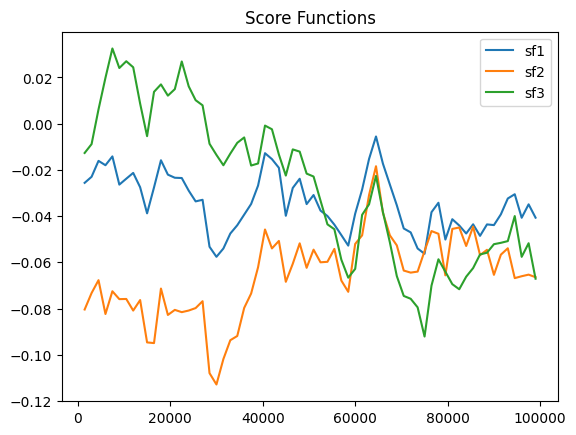

In [ ]:
plt.plot(arraystep, attaysp1, label = "sf1")
plt.plot(arraystep, attaysp2, label = "sf2")
plt.plot(arraystep, attaysp3, label = "sf3")
plt.legend()
plt.title("Score Functions")
plt.show()


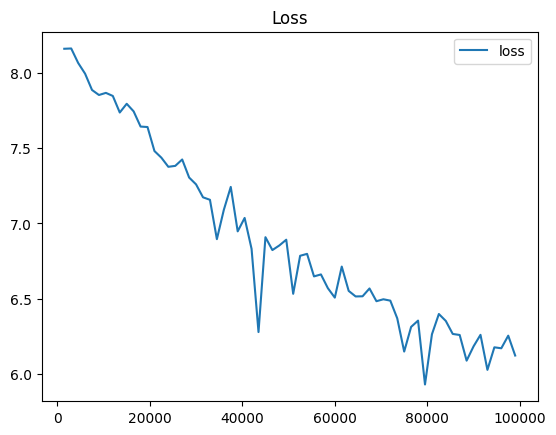

In [ ]:
arrayloss = [t.cpu().detach().numpy().tolist() for t in arrayloss]

plt.plot(arraystep, arrayloss, label = "loss")
plt.legend()
plt.title("Loss")
plt.show()

# Best Models

In [ ]:
print("Best for score function #1: ", [arraystep[idx] for idx, x in enumerate(attaysp1) if x == max(attaysp1)])
print("Best for score function #2: ", [arraystep[idx] for idx, x in enumerate(attaysp2) if x == max(attaysp2)])
print("Best for score function #3: ", [arraystep[idx] for idx, x in enumerate(attaysp3) if x == max(attaysp3)])
print("Best according to the loss function: ", [arraystep[idx] for idx, x in enumerate(arrayloss) if x == min(arrayloss)])

Best for score function #1:  [64500]
Best for score function #2:  [64500]
Best for score function #3:  [7500]
Best according to the loss function:  [79500]
